In [1]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append("..")

from common.training import *
from common.utils import load_sql_to_df, save_to_sql, plot_history

import datasets
import data_process as dp
from models import SentimentAnalysisLSTM

import numpy as np
import pandas as pd
import sqlite3 as db
import torchtext
import torch
import torch.utils
import matplotlib.pyplot as plt

2023-03-30 23:56:55.770125: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-30 23:56:57.826124: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-30 23:56:57.826653: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-03-

In [2]:
#reproducibility
# torch.manual_seed(0)
# random.seed(0)
# np.random.seed(0)

## Load data

In [3]:
important_columns = ["position", "move", "comment", "sentiment"]
moves_df = load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db")[important_columns]
moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


## Preprocessing

In [4]:
glove_embbedings = torchtext.vocab.GloVe(name="6B", dim=200, cache="../../.vector_cache/")
datasets.add_padding_vector_to_embeddings(glove_embbedings)

In [5]:
comments_df = dp.prepare_data_for_sentiment_analysis_training(moves_df, glove_embbedings.stoi, max_len=150)
comments_df

,comment,sentiment,preprocessed_comment
10450,threatening and,1,"[threaten, and]"
16831,threatens mate,1,"[threaten, mate]"
17224,if mate,1,"[if, mate]"
13786,best.,1,"[well, .]"
15355,nope!,1,"[nope, !]"
...,...,...,...
9811,? like now. so now i go for more damage since ...,0,"[?, like, now, ., so, now, go, for, more, dama..."
9001,?? as annabel took which i anticipated. but i ...,0,"[?, ?, as, annabel, take, which, anticipate, ...."
6225,?? this move however is even worse. in fact it...,0,"[?, ?, this, move, however, be, even, bad, ., ..."
19726,not knowing what else to do here i played this...,0,"[not, know, what, else, to, do, here, play, th..."


In [6]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

In [7]:
train_df, test_df = dp.df_train_test_split(comments_df, comment_col='preprocessed_comment', test_size=0.1)
display(train_df)
display(test_df)

,comment,sentiment,preprocessed_comment
9825,??,0,"[?, ?]"
1326,! threatening,1,"[!, threaten]"
8203,? passive,0,"[?, passive]"
16717,now if,1,"[now, if]"
18824,blunder!,0,"[blunder, !]"
...,...,...,...
18693,this also develops but i view it as an inaccur...,0,"[this, also, develop, but, view, it, as, an, i..."
9811,? like now. so now i go for more damage since ...,0,"[?, like, now, ., so, now, go, for, more, dama..."
17468,i understand this move very well as it's the k...,0,"[understand, this, move, very, well, as, it, b..."
6225,?? this move however is even worse. in fact it...,0,"[?, ?, this, move, however, be, even, bad, ., ..."


,comment,sentiment,preprocessed_comment
19268,finally!,1,"[finally, !]"
2881,! deflection,1,"[!, deflection]"
15815,great!,1,"[great, !]"
6182,was required,0,"[be, require]"
18339,alternative variation,0,"[alternative, variation]"
...,...,...,...
17079,with that in mind i know why black moved here....,0,"[with, that, in, mind, know, why, black, move,..."
18364,however mike played this instead. so i said i ...,0,"[however, mike, play, this, instead, ., so, sa..."
8801,? this is where i make a mistake of only calcu...,0,"[?, this, be, where, make, a, mistake, of, onl..."
16056,i'm not sure why he moved here but this is his...,0,"[be, not, sure, why, he, move, here, but, this..."


In [8]:
train_dataset = datasets.PretrainedEmbeddingsIndicesDataset(train_df, glove_embbedings, comment_col='preprocessed_comment')
test_dataset = datasets.PretrainedEmbeddingsIndicesDataset(test_df, glove_embbedings,  comment_col='preprocessed_comment')

## Comments' length

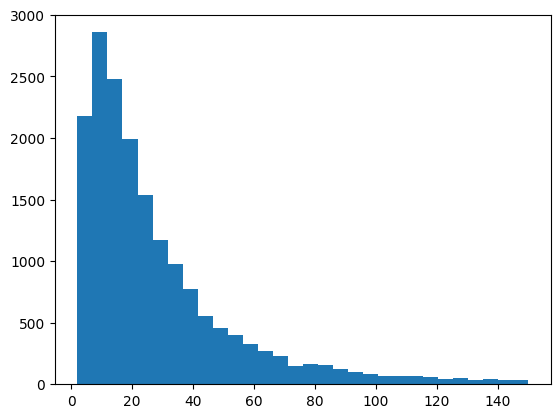

In [9]:
lengths = [len(x) for x,_ in train_dataset]
plt.hist(lengths, bins=30)
plt.show()

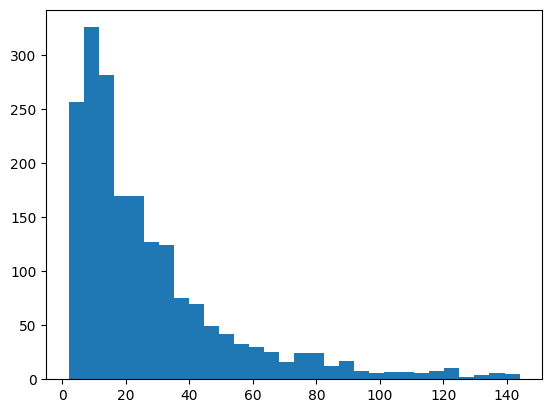

In [10]:
lengths = [len(x) for x,_ in test_dataset]
plt.hist(lengths, bins=30)
plt.show()

## Training

In [11]:
train_loader = datasets.DataLoaderPadding(dataset=train_dataset, batch_size=64)
test_loader = datasets.DataLoaderPadding(dataset=test_dataset, batch_size=64)

In [12]:
model = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=256, num_layers=3, dropout=0.5)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
history = train_loop(train_loader, model, optimizer, val_dataloader=test_loader, num_epochs=50, verbose=True)

Epoch 1/50
Train loss: 0.363802, accuracy: 82.81%
Val loss:  0.477875, accuracy: 81.67%
-----------------------------
Epoch 2/50
Train loss: 0.346813, accuracy: 83.80%
Val loss:  0.781990, accuracy: 61.84%
-----------------------------
Epoch 3/50
Train loss: 0.313849, accuracy: 83.85%
Val loss:  0.471634, accuracy: 80.79%
-----------------------------
Epoch 4/50
Train loss: 0.275239, accuracy: 86.70%
Val loss:  0.354966, accuracy: 82.44%
-----------------------------
Epoch 5/50
Train loss: 0.255941, accuracy: 87.65%
Val loss:  0.332686, accuracy: 81.67%
-----------------------------
Epoch 6/50
Train loss: 0.249411, accuracy: 88.33%
Val loss:  0.278277, accuracy: 86.51%
-----------------------------
Epoch 7/50
Train loss: 0.232197, accuracy: 89.35%
Val loss:  0.288928, accuracy: 86.41%
-----------------------------
Epoch 8/50
Train loss: 0.222348, accuracy: 89.94%
Val loss:  0.249802, accuracy: 88.77%
-----------------------------
Epoch 9/50
Train loss: 0.206841, accuracy: 90.68%
Val lo

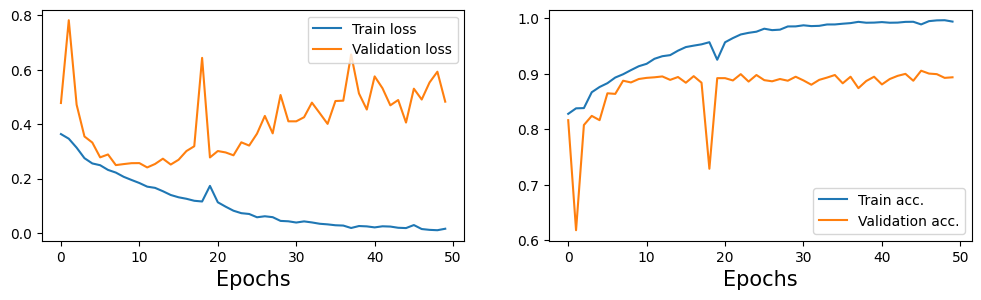

In [14]:
plot_history(history)

In [15]:
model_2 = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=128, num_layers=2, dropout=0.5)
model_2 = model_2.to(device)
optimizer = torch.optim.Adam(model_2.parameters(), lr=0.001)
history_2 = train_loop(train_loader, model_2, optimizer, val_dataloader=test_loader, num_epochs=50, verbose=True)

Epoch 1/50
Train loss: 0.339812, accuracy: 83.63%
Val loss:  0.371858, accuracy: 81.51%
-----------------------------
Epoch 2/50
Train loss: 0.318434, accuracy: 85.64%
Val loss:  0.350507, accuracy: 81.31%
-----------------------------
Epoch 3/50
Train loss: 0.289771, accuracy: 86.11%
Val loss:  0.328854, accuracy: 85.32%
-----------------------------
Epoch 4/50
Train loss: 0.266310, accuracy: 87.59%
Val loss:  0.290190, accuracy: 85.02%
-----------------------------
Epoch 5/50
Train loss: 0.283156, accuracy: 86.79%
Val loss:  0.509553, accuracy: 65.81%
-----------------------------
Epoch 6/50
Train loss: 0.407823, accuracy: 76.29%
Val loss:  0.358172, accuracy: 80.59%
-----------------------------
Epoch 7/50
Train loss: 0.290743, accuracy: 85.64%
Val loss:  0.294638, accuracy: 84.91%
-----------------------------
Epoch 8/50
Train loss: 0.258052, accuracy: 87.59%
Val loss:  0.278167, accuracy: 86.51%
-----------------------------
Epoch 9/50
Train loss: 0.241980, accuracy: 88.77%
Val lo

In [16]:
test_model(test_loader, model_2)

Test Error: Accuracy: 89.70%, Avg loss: 0.515010


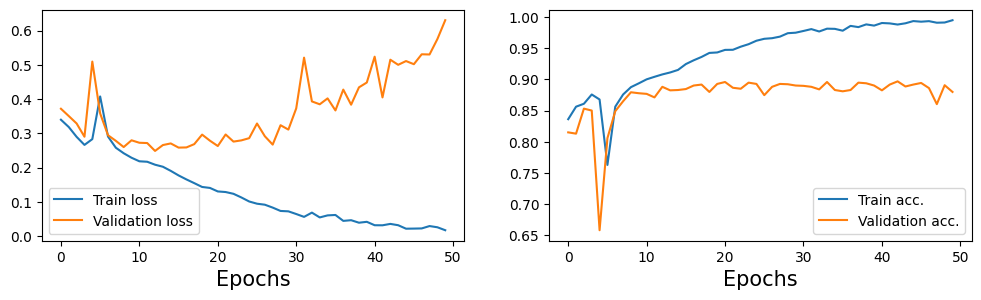

In [17]:
plot_history(history_2)

In [18]:
model_3 = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=128, num_layers=3, dropout=0.2, bidirectional=True)
model_3 = model_3.to(device)
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.001, weight_decay=0.0002)
history_3 = train_loop(train_loader, model_3, optimizer, val_dataloader=test_loader, num_epochs=60, verbose=True)

Epoch 1/60
Train loss: 0.377987, accuracy: 82.63%
Val loss:  0.440714, accuracy: 82.96%
-----------------------------
Epoch 2/60
Train loss: 0.329279, accuracy: 84.14%
Val loss:  0.421578, accuracy: 80.12%
-----------------------------
Epoch 3/60
Train loss: 0.301406, accuracy: 85.80%
Val loss:  0.319998, accuracy: 82.44%
-----------------------------
Epoch 4/60
Train loss: 0.313936, accuracy: 86.87%
Val loss:  0.429160, accuracy: 84.86%
-----------------------------
Epoch 5/60
Train loss: 0.327288, accuracy: 85.99%
Val loss:  0.592390, accuracy: 75.23%
-----------------------------
Epoch 6/60
Train loss: 0.287392, accuracy: 87.22%
Val loss:  0.291878, accuracy: 85.89%
-----------------------------
Epoch 7/60
Train loss: 0.294531, accuracy: 87.08%
Val loss:  0.343542, accuracy: 85.48%
-----------------------------
Epoch 8/60
Train loss: 0.274329, accuracy: 87.10%
Val loss:  0.284811, accuracy: 85.84%
-----------------------------
Epoch 9/60
Train loss: 0.254204, accuracy: 88.23%
Val lo

Test Error: Accuracy: 89.24%, Avg loss: 0.347648


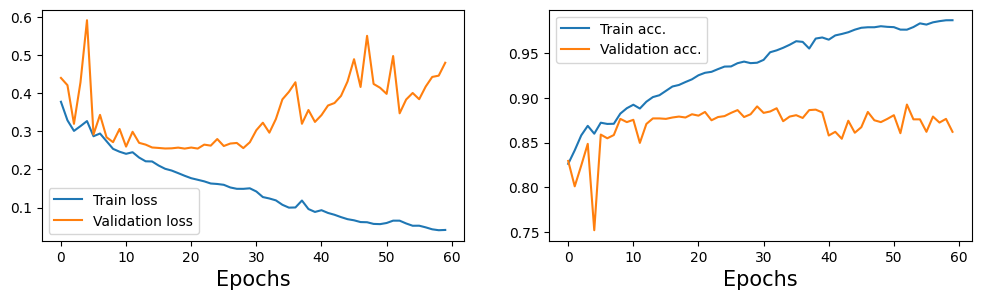

In [19]:
test_model(test_loader, model_3)
plot_history(history_3)

In [20]:
torch.cuda.empty_cache()
model_4 = SentimentAnalysisLSTM(embeddings=glove_embbedings, hidden_dim=256, num_layers=3, dropout=0.5, bidirectional=True)
model_4 = model_4.to(device)
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)
history_4 = train_loop(train_loader, model_4, optimizer, val_dataloader=test_loader, num_epochs=60, verbose=True)

Epoch 1/60
Train loss: 0.375249, accuracy: 81.81%
Val loss:  0.457802, accuracy: 73.17%
-----------------------------
Epoch 2/60
Train loss: 0.307166, accuracy: 85.11%
Val loss:  0.579840, accuracy: 77.19%
-----------------------------
Epoch 3/60
Train loss: 0.288918, accuracy: 86.51%
Val loss:  0.294715, accuracy: 85.94%
-----------------------------
Epoch 4/60
Train loss: 0.257848, accuracy: 87.71%
Val loss:  0.289227, accuracy: 85.68%
-----------------------------
Epoch 5/60
Train loss: 0.247320, accuracy: 88.32%
Val loss:  0.270652, accuracy: 87.38%
-----------------------------
Epoch 6/60
Train loss: 0.241351, accuracy: 88.54%
Val loss:  0.280470, accuracy: 84.81%
-----------------------------
Epoch 7/60
Train loss: 0.231040, accuracy: 89.24%
Val loss:  0.252106, accuracy: 88.31%
-----------------------------
Epoch 8/60
Train loss: 0.211481, accuracy: 90.25%
Val loss:  0.272049, accuracy: 88.36%
-----------------------------
Epoch 9/60
Train loss: 0.199451, accuracy: 91.24%
Val lo

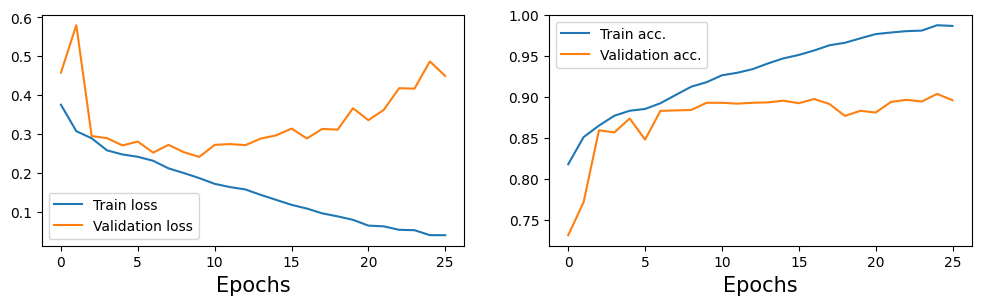

In [21]:
plot_history(history_4)

In [25]:
# torch.save(model.state_dict(), "../../models/LSTM_glove200_60ep.model")
# model.load_state_dict(torch.load("../../models/LSTM_glove200_60ep.model"))
# model = model.to(device)

## Testing

In [38]:
test_model(test_loader, model_2)

Test Error: Accuracy: 91.25%, Avg loss: 0.238997


In [39]:
test_model(train_loader, model_2)

Test Error: Accuracy: 93.46%, Avg loss: 0.163211


In [40]:
boundary = 0.1

In [42]:
test_high_confidence(test_loader, model_3, low_boundary=boundary)

High confidence samples: 1356/1931 = 70.22%
Accuracy for high confidence samples: 97.1%


In [43]:
all_moves_df = load_sql_to_df("SELECT * FROM english_annotated_moves", "../../chess.db",)[important_columns]
all_moves_df

,position,move,comment,sentiment
0,rnbqkbnr/pppppppp/8/8/8/8/PPPPPPPP/RNBQKBNR w ...,e2e4,This is my first gameknot game against someone...,2
1,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...,b1c3,"I've been playing the Vienna Gambit as white, ...",-1
2,rnbqkbnr/pppp1ppp/8/4p3/4P3/2N5/PPPP1PPP/R1BQK...,f8c5,Minor disappointment.,-1
3,r1bqk2r/pppp1ppp/2n2n2/2b1p3/2B1P3/2NP4/PPP2PP...,f2f4,"My idea here is to expand on the kingside, dri...",-1
4,r1bqk2r/ppp2ppp/3p1n2/n1b1pP2/2B1P3/2NP4/PPP3P...,d1f3,"Maybe this isn't the greatest plan, since with...",0
...,...,...,...,...
326634,rnb5/p2p1P1N/7p/1pR5/6P1/4k3/2P1B3/3Q1RK1 b - ...,b5b4,Pawn,-1
326635,rnb5/p2p1P1N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f7f8q,Check mate in two moves,-1
326636,rnb2Q2/p2p3N/7p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 b -...,d7d6,Pawn,-1
326637,rnb2Q2/p6N/3p3p/2R5/1p4P1/4k3/2P1B3/3Q1RK1 w -...,f8e8,Check,-1


In [45]:
moves_df_with_preprocessed_comments = dp.prepare_data_for_sentiment_analysis_prediction(all_moves_df, glove_embbedings.stoi, max_len=150)
moves_df_with_preprocessed_comments

,position,move,comment,sentiment,preprocessed_comment
63267,2kr1b1r/ppp2ppp/2n5/4pb2/2P5/P1NP1PqP/1P4P1/R1...,e1d2,Forced.,-1,"[force, .]"
4415,r1b3k1/5p1r/p7/q1n1Q2p/2p1P1p1/6P1/PP2N1BP/R4R...,c8b7,Prevents Qe8,-1,"[prevent, qe8]"
302202,2k5/p1p2pp1/2p1p1r1/7p/4P3/P4P2/1PPr3K/R4R2 w ...,h2h3,a role,-1,"[a, role]"
221065,r1b2r2/p2n3k/1p4pp/2pp4/3P2Q1/P3P3/5PPP/2R3KR ...,d4c5,trading down,-1,"[trade, down]"
165029,r2q4/2p2k2/P1p2pp1/2P5/3p3R/6Q1/P4PPK/8 b - - ...,f7g7,prevents it,-1,"[prevent, it]"
...,...,...,...,...,...
237207,rnbqkb1r/pp2pppp/5n2/3p4/3P4/5N2/PPP2PPP/RNBQK...,f1b5,"So, I said, and, that's a good thing because t...",-1,"[so, ,, say, ,, and, ,, that, be, a, good, thi..."
294455,r2qk2r/5pp1/p3pn1p/1p1pBb2/2pP4/bPP1P2P/P2NBPP...,b3c4,"good move , white cant avoid blacks threat Bb2...",-1,"[good, move, ,, white, can, not, avoid, black,..."
277372,rnbqkbnr/ppp2ppp/3p4/4p3/3PP3/5N2/PPP2PPP/RNBQ...,f7f6,"But, she, however, does not. The most common m...",-1,"[but, ,, she, ,, however, ,, do, not, ., the, ..."
264663,2k4r/p2p3p/6pR/6p1/P3Pr2/2P2P2/B1P3PP/5K2 b - ...,f4h4,"This is why my remaining R, as noted earlier, ...",-1,"[this, be, why, my, remain, r, ,, as, note, ea..."


In [46]:
moves_df_with_preprocessed_comments = moves_df_with_preprocessed_comments.reset_index()
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,63267,2kr1b1r/ppp2ppp/2n5/4pb2/2P5/P1NP1PqP/1P4P1/R1...,e1d2,Forced.,-1,"[force, .]"
1,4415,r1b3k1/5p1r/p7/q1n1Q2p/2p1P1p1/6P1/PP2N1BP/R4R...,c8b7,Prevents Qe8,-1,"[prevent, qe8]"
2,302202,2k5/p1p2pp1/2p1p1r1/7p/4P3/P4P2/1PPr3K/R4R2 w ...,h2h3,a role,-1,"[a, role]"
3,221065,r1b2r2/p2n3k/1p4pp/2pp4/3P2Q1/P3P3/5PPP/2R3KR ...,d4c5,trading down,-1,"[trade, down]"
4,165029,r2q4/2p2k2/P1p2pp1/2P5/3p3R/6Q1/P4PPK/8 b - - ...,f7g7,prevents it,-1,"[prevent, it]"
...,...,...,...,...,...,...
315743,237207,rnbqkb1r/pp2pppp/5n2/3p4/3P4/5N2/PPP2PPP/RNBQK...,f1b5,"So, I said, and, that's a good thing because t...",-1,"[so, ,, say, ,, and, ,, that, be, a, good, thi..."
315744,294455,r2qk2r/5pp1/p3pn1p/1p1pBb2/2pP4/bPP1P2P/P2NBPP...,b3c4,"good move , white cant avoid blacks threat Bb2...",-1,"[good, move, ,, white, can, not, avoid, black,..."
315745,277372,rnbqkbnr/ppp2ppp/3p4/4p3/3PP3/5N2/PPP2PPP/RNBQ...,f7f6,"But, she, however, does not. The most common m...",-1,"[but, ,, she, ,, however, ,, do, not, ., the, ..."
315746,264663,2k4r/p2p3p/6pR/6p1/P3Pr2/2P2P2/B1P3PP/5K2 b - ...,f4h4,"This is why my remaining R, as noted earlier, ...",-1,"[this, be, why, my, remain, r, ,, as, note, ea..."


In [52]:
unlabeled_dataset = datasets.PretrainedEmbeddingsIndicesDataset(moves_df_with_preprocessed_comments, glove_embbedings, comment_col="preprocessed_comment")
unlabeled_loader = datasets.DataLoaderPadding(dataset=unlabeled_dataset, batch_size = 128)
predictions = predict(unlabeled_loader, model_2, low_boundary=0.4)
moves_df_with_preprocessed_comments.loc[:, "sentiment"] = predictions.numpy().astype(np.int32)
moves_df_with_preprocessed_comments

,index,position,move,comment,sentiment,preprocessed_comment
0,63267,2kr1b1r/ppp2ppp/2n5/4pb2/2P5/P1NP1PqP/1P4P1/R1...,e1d2,Forced.,1,"[force, .]"
1,4415,r1b3k1/5p1r/p7/q1n1Q2p/2p1P1p1/6P1/PP2N1BP/R4R...,c8b7,Prevents Qe8,1,"[prevent, qe8]"
2,302202,2k5/p1p2pp1/2p1p1r1/7p/4P3/P4P2/1PPr3K/R4R2 w ...,h2h3,a role,-1,"[a, role]"
3,221065,r1b2r2/p2n3k/1p4pp/2pp4/3P2Q1/P3P3/5PPP/2R3KR ...,d4c5,trading down,1,"[trade, down]"
4,165029,r2q4/2p2k2/P1p2pp1/2P5/3p3R/6Q1/P4PPK/8 b - - ...,f7g7,prevents it,1,"[prevent, it]"
...,...,...,...,...,...,...
315743,237207,rnbqkb1r/pp2pppp/5n2/3p4/3P4/5N2/PPP2PPP/RNBQK...,f1b5,"So, I said, and, that's a good thing because t...",0,"[so, ,, say, ,, and, ,, that, be, a, good, thi..."
315744,294455,r2qk2r/5pp1/p3pn1p/1p1pBb2/2pP4/bPP1P2P/P2NBPP...,b3c4,"good move , white cant avoid blacks threat Bb2...",1,"[good, move, ,, white, can, not, avoid, black,..."
315745,277372,rnbqkbnr/ppp2ppp/3p4/4p3/3PP3/5N2/PPP2PPP/RNBQ...,f7f6,"But, she, however, does not. The most common m...",0,"[but, ,, she, ,, however, ,, do, not, ., the, ..."
315746,264663,2k4r/p2p3p/6pR/6p1/P3Pr2/2P2P2/B1P3PP/5K2 b - ...,f4h4,"This is why my remaining R, as noted earlier, ...",0,"[this, be, why, my, remain, r, ,, as, note, ea..."


In [53]:
classified_comments = moves_df_with_preprocessed_comments[moves_df_with_preprocessed_comments.sentiment.isin([0,1])].reset_index()
classified_comments

,level_0,index,position,move,comment,sentiment,preprocessed_comment
0,0,63267,2kr1b1r/ppp2ppp/2n5/4pb2/2P5/P1NP1PqP/1P4P1/R1...,e1d2,Forced.,1,"[force, .]"
1,1,4415,r1b3k1/5p1r/p7/q1n1Q2p/2p1P1p1/6P1/PP2N1BP/R4R...,c8b7,Prevents Qe8,1,"[prevent, qe8]"
2,3,221065,r1b2r2/p2n3k/1p4pp/2pp4/3P2Q1/P3P3/5PPP/2R3KR ...,d4c5,trading down,1,"[trade, down]"
3,4,165029,r2q4/2p2k2/P1p2pp1/2P5/3p3R/6Q1/P4PPK/8 b - - ...,f7g7,prevents it,1,"[prevent, it]"
4,5,19167,r1bqkbnr/p1p2ppp/3p4/2p1p3/2P1P3/5N2/PP1P1PPP/...,d2d3,facing off,1,"[face, off]"
...,...,...,...,...,...,...,...
276886,315743,237207,rnbqkb1r/pp2pppp/5n2/3p4/3P4/5N2/PPP2PPP/RNBQK...,f1b5,"So, I said, and, that's a good thing because t...",0,"[so, ,, say, ,, and, ,, that, be, a, good, thi..."
276887,315744,294455,r2qk2r/5pp1/p3pn1p/1p1pBb2/2pP4/bPP1P2P/P2NBPP...,b3c4,"good move , white cant avoid blacks threat Bb2...",1,"[good, move, ,, white, can, not, avoid, black,..."
276888,315745,277372,rnbqkbnr/ppp2ppp/3p4/4p3/3PP3/5N2/PPP2PPP/RNBQ...,f7f6,"But, she, however, does not. The most common m...",0,"[but, ,, she, ,, however, ,, do, not, ., the, ..."
276889,315746,264663,2k4r/p2p3p/6pR/6p1/P3Pr2/2P2P2/B1P3PP/5K2 b - ...,f4h4,"This is why my remaining R, as noted earlier, ...",0,"[this, be, why, my, remain, r, ,, as, note, ea..."


In [54]:
con = db.connect("../../chess.db")
classified_comments.sentiment =  pd.to_numeric(classified_comments.sentiment)
classified_comments_to_save = classified_comments[['position', 'move', 'comment', 'sentiment']]
classified_comments_to_save.to_sql('classified_moves', con, if_exists='replace')

276891

In [58]:
angelfire_moves = load_sql_to_df("SELECT * FROM angelfire_moves", "../../chess.db")[['position', 'move', 'comment']]
angelfire_moves['sentiment'] = -1
angelfire_moves

,position,move,comment,sentiment
0,r1bq1rk1/2p1bppp/p1n2n2/1p1pp3/4P3/1BP2N2/PP1P...,d2d3,"An excellent reply, avoiding the complications...",-1
1,r3r1k1/1b2bppp/p1n2n2/1ppqp1B1/8/2PP1N2/PPB1QP...,g5h4,threatening to win the e-pawn with Bg3 as well...,-1
2,r3r1k1/1b2bppp/p1n2n2/1ppqp3/7B/2PP1N2/PPB1QPP...,a8d8,Apparently Black still stands very well. His p...,-1
3,3rr1k1/1b2bppp/p1n2n2/1ppqp3/7B/2PP1N2/PPB1QPP...,c2b3,This deep moves demonstrates otherwise,-1
4,4r1k1/1b2bppp/p4n2/1pp1R3/7B/1BPr4/PP3PPP/R4NK...,c5c4,"The Black pieces are\nawkardly ties up, while ...",-1
...,...,...,...,...
27500,2Q2b1k/1p3q2/p6p/5n2/3p1r2/5NR1/PP3K2/7R w - -...,g3h3,"White defends very\nactively, with his major p...",-1
27501,2Q2b1k/1p3q2/p6p/5n2/3p1r2/5N1R/PP3K2/7R b - -...,d4d3,"A decoy, to tempt the White Queen\naway from t...",-1
27502,5b1k/1p6/p6p/5n2/5r2/3Q1N1R/P3K3/q6R b - - 3 43,a1a2,And this brings about a very unusual middlegam...,-1
27503,5b1k/1p6/p6p/5n2/5r2/3Q3R/q2NK3/7R b - - 1 44,f4d4,Consistent chess. Black hammers away at the\nw...,-1


In [59]:
angelfire_moves_preprocessed = dp.prepare_data_for_sentiment_analysis_prediction(angelfire_moves, glove_embbedings.stoi, max_len=150)
angelfire_moves_preprocessed

,position,move,comment,sentiment,preprocessed_comment
25957,3qkb1r/3b3p/prnp2p1/3Npp2/2N1n3/R1P5/1P3PPP/3Q...,c4b6,according to Fritz7,-1,"[accord, to]"
11058,2rr2k1/pp1q1pb1/5pp1/3P1b1p/2nP4/1QN2BNP/PP3PP...,c4d6,Blockades.,-1,"[blockade, .]"
4863,1r1n3R/ppk1qpQ1/2bppNp1/2p5/2P2P2/2PP2P1/P2KP1...,c7b6,22...Bxg2 23.Re8,-1,"[22, ...]"
13104,rnbqkb1r/pp2pppp/3p1n2/8/3NP3/2N5/PPP2PPP/R1BQ...,a7a6,Covers b5,-1,"[cover, b5]"
1973,2r1k2r/1bqp1ppp/1p2pn2/p7/2P5/P1Q1PNP1/1P3PBP/...,d7d5,well timed,-1,"[well, time]"
...,...,...,...,...,...
25658,4r3/6kp/3p2p1/2q1p1b1/8/5BP1/Q4PKP/1R6 b - - 8 36,e5e4,At the end Polgar could force an entry to Blac...,-1,"[at, the, end, polgar, could, force, an, entry..."
22580,rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...,g1f3,"This could be just a move-order trick, or a si...",-1,"[this, could, be, just, a, move, -, order, tri..."
9418,r1bq1rk1/ppp3pp/2np1n2/5p2/2PPpN2/2P1P3/P4PPP/...,h2h4,Kramnik mentioned that all the moves up to her...,-1,"[kramnik, mention, that, all, the, move, up, t..."
1723,3r1qk1/1p1n2p1/r1p2p1p/p2Pp3/P1P1P3/3Q1P2/5BPP...,c6c5,ACT III) T\nhe move finishes the first stage ...,-1,"[act, iii, ), t, he, move, finish, the, first,..."


In [61]:
unlabeled_dataset = datasets.PretrainedEmbeddingsIndicesDataset(angelfire_moves_preprocessed, glove_embbedings, comment_col="preprocessed_comment")
unlabeled_loader = datasets.DataLoaderPadding(dataset=unlabeled_dataset, batch_size = 128)
predictions = predict(unlabeled_loader, model_2, low_boundary=0.4)
angelfire_moves_preprocessed.loc[:, "sentiment"] = predictions.numpy().astype(np.int32)
angelfire_moves_preprocessed

,position,move,comment,sentiment,preprocessed_comment
25957,3qkb1r/3b3p/prnp2p1/3Npp2/2N1n3/R1P5/1P3PPP/3Q...,c4b6,according to Fritz7,1,"[accord, to]"
11058,2rr2k1/pp1q1pb1/5pp1/3P1b1p/2nP4/1QN2BNP/PP3PP...,c4d6,Blockades.,1,"[blockade, .]"
4863,1r1n3R/ppk1qpQ1/2bppNp1/2p5/2P2P2/2PP2P1/P2KP1...,c7b6,22...Bxg2 23.Re8,0,"[22, ...]"
13104,rnbqkb1r/pp2pppp/3p1n2/8/3NP3/2N5/PPP2PPP/R1BQ...,a7a6,Covers b5,1,"[cover, b5]"
1973,2r1k2r/1bqp1ppp/1p2pn2/p7/2P5/P1Q1PNP1/1P3PBP/...,d7d5,well timed,1,"[well, time]"
...,...,...,...,...,...
25658,4r3/6kp/3p2p1/2q1p1b1/8/5BP1/Q4PKP/1R6 b - - 8 36,e5e4,At the end Polgar could force an entry to Blac...,0,"[at, the, end, polgar, could, force, an, entry..."
22580,rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...,g1f3,"This could be just a move-order trick, or a si...",0,"[this, could, be, just, a, move, -, order, tri..."
9418,r1bq1rk1/ppp3pp/2np1n2/5p2/2PPpN2/2P1P3/P4PPP/...,h2h4,Kramnik mentioned that all the moves up to her...,0,"[kramnik, mention, that, all, the, move, up, t..."
1723,3r1qk1/1p1n2p1/r1p2p1p/p2Pp3/P1P1P3/3Q1P2/5BPP...,c6c5,ACT III) T\nhe move finishes the first stage ...,1,"[act, iii, ), t, he, move, finish, the, first,..."


In [64]:
angelfire_moves.dtypes

position                object
move                    object
comment                 object
sentiment                int64
preprocessed_comment    object
dtype: object

In [66]:
classified_comments_angelfire = angelfire_moves_preprocessed[angelfire_moves_preprocessed.sentiment.isin([0,1])].reset_index()
classified_comments_angelfire

,index,position,move,comment,sentiment,preprocessed_comment
0,25957,3qkb1r/3b3p/prnp2p1/3Npp2/2N1n3/R1P5/1P3PPP/3Q...,c4b6,according to Fritz7,1,"[accord, to]"
1,11058,2rr2k1/pp1q1pb1/5pp1/3P1b1p/2nP4/1QN2BNP/PP3PP...,c4d6,Blockades.,1,"[blockade, .]"
2,4863,1r1n3R/ppk1qpQ1/2bppNp1/2p5/2P2P2/2PP2P1/P2KP1...,c7b6,22...Bxg2 23.Re8,0,"[22, ...]"
3,13104,rnbqkb1r/pp2pppp/3p1n2/8/3NP3/2N5/PPP2PPP/R1BQ...,a7a6,Covers b5,1,"[cover, b5]"
4,1973,2r1k2r/1bqp1ppp/1p2pn2/p7/2P5/P1Q1PNP1/1P3PBP/...,d7d5,well timed,1,"[well, time]"
...,...,...,...,...,...,...
24450,25658,4r3/6kp/3p2p1/2q1p1b1/8/5BP1/Q4PKP/1R6 b - - 8 36,e5e4,At the end Polgar could force an entry to Blac...,0,"[at, the, end, polgar, could, force, an, entry..."
24451,22580,rnbqkb1r/pppppppp/5n2/8/3P4/8/PPP1PPPP/RNBQKBN...,g1f3,"This could be just a move-order trick, or a si...",0,"[this, could, be, just, a, move, -, order, tri..."
24452,9418,r1bq1rk1/ppp3pp/2np1n2/5p2/2PPpN2/2P1P3/P4PPP/...,h2h4,Kramnik mentioned that all the moves up to her...,0,"[kramnik, mention, that, all, the, move, up, t..."
24453,1723,3r1qk1/1p1n2p1/r1p2p1p/p2Pp3/P1P1P3/3Q1P2/5BPP...,c6c5,ACT III) T\nhe move finishes the first stage ...,1,"[act, iii, ), t, he, move, finish, the, first,..."


In [67]:
con = db.connect("../../chess.db")
classified_comments.sentiment =  pd.to_numeric(classified_comments_angelfire.sentiment)
classified_comments_to_save = classified_comments_angelfire[['position', 'move', 'comment', 'sentiment']]
classified_comments_to_save.to_sql('classified_moves', con, if_exists='append')

24455